In [1]:
from collections import Counter
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.ops import variable_scope
import jieba
%matplotlib inline
%load_ext watermark
%watermark -p tensorflow -v -m

CPython 2.7.6
IPython 5.1.0

tensorflow 1.0.1

compiler   : GCC 4.8.4
system     : Linux
release    : 4.4.0-21-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
# 参数
cell_size = 100
embedding_size = 100
buckets = [(8, 8), (12, 12), (20, 20)]

## 读入语料并处理

In [3]:
basedir = './'
files = {"train": {'en': basedir + 'TED_en_train.txt',
                   'zh': basedir + 'TED_zh_train.txt'},
         "test": {'en': basedir + 'TED_en_test.txt',
                  'zh': basedir + 'TED_zh_test.txt'}}
lines_to_read = 100
VOCAB_MIN_FREQ = 1 # 计入词表的最小词频，小于则记为 UNK

In [4]:
!head TED_en_train.txt

### 读取文本文件，tokenize 得到 sentences（word lists）

decoder inputs 在句首尾分别添加特殊 token

In [5]:
_PAD, _GO, _EOS, _UNK = '<PAD>', '<GO>', '<EOS>', '<UNK>'
_PAD_ID, _GO_ID, _EOS_ID, _UNK_ID = 0, 1, 2, 3
_START_VOCAB = (_PAD, _GO, _EOS, _UNK)

In [6]:
def en_tokenizer(sentence):
    """英文句子分词"""
    _word_split = re.compile("([.,!?\"':;])")
    words = []
    for space_separated_fragment in sentence.strip().split():
        words.extend(_word_split.split(space_separated_fragment))
    return [w for w in words if w]

def zh_tokenizer(sentence):
    """中文句子分词"""
    return [w for w in jieba.cut(sentence.strip().decode('utf-8')) if w not in (' ', '\t', '\n')]

def read_sentences(encoder_file, decoder_file, lines_to_read=None):
    """英文到中文"""
    # 读取文件
    with open(encoder_file, 'r') as f:
        enc_lines = f.readlines()[:lines_to_read] if lines_to_read else f.readlines()
    with open(decoder_file, 'r') as f:
        dec_lines = f.readlines()[:lines_to_read] if lines_to_read else f.readlines()
    assert len(enc_lines) == len(dec_lines)
    
    num_lines = len(enc_lines)
    
    encoder_sentences = []
    decoder_sentences = []
    
    for i in range(num_lines):
        enc_sentence = en_tokenizer(enc_lines[i])
        dec_sentence = zh_tokenizer(dec_lines[i])
        if enc_sentence and dec_sentence:
            encoder_sentences.append(enc_sentence)
            decoder_sentences.append(dec_sentence)
    return encoder_sentences, decoder_sentences

In [7]:
encoder_sentences, decoder_sentences = read_sentences(
files['train']['en'], files['train']['zh'], lines_to_read=lines_to_read)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.388 seconds.
Prefix dict has been built succesfully.


In [8]:
encoder_sentences_test, decoder_sentences_test = read_sentences(
files['test']['en'], files['test']['zh'], lines_to_read=lines_to_read)

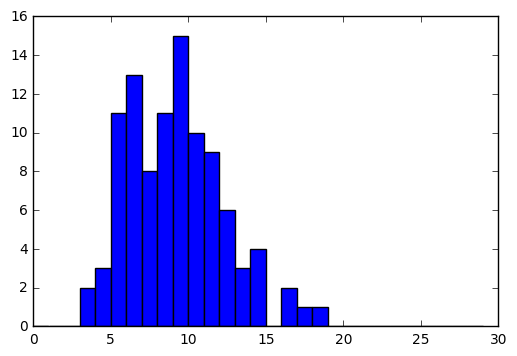

In [9]:
def plot_length_histogram(sentences):
    lengths = np.asarray([len(s) for s in sentences])
    plt.hist(lengths, bins=range(30));
plot_length_histogram(encoder_sentences)

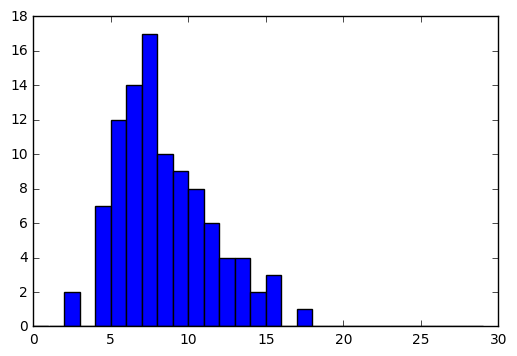

In [10]:
plot_length_histogram(decoder_sentences)

### 由训练文件的 word lists 得到 vocab

In [11]:
def build_vocab(sentences):
    """生成词表，前几个位置留给 _START_VOCAB 的特殊 token"""
    vocab = list(_START_VOCAB)
    words_flat = [w for s in sentences for w in s]
    word_cnt = Counter(words_flat)
    for word, count in word_cnt.most_common():
        if count >= VOCAB_MIN_FREQ:
            vocab.append(word)
    return vocab

In [12]:
vocab_enc = build_vocab(encoder_sentences)
vocab_dec = build_vocab(decoder_sentences)
num_encoder_symbols = len(vocab_enc)
num_decoder_symbols = len(vocab_dec)

In [13]:
word2id_enc = {w: i for i, w in enumerate(vocab_enc)}
word2id_dec = {w: i for i, w in enumerate(vocab_dec)}
len(word2id_enc), len(word2id_dec)

(307, 353)

### decoder inputs 句子首尾加 token

In [14]:
def add_tokens(sentences):
    for i in range(len(sentences)):
        sentences[i] = [_GO] + sentences[i] + [_EOS]
    return sentences

In [15]:
decoder_sentences = add_tokens(decoder_sentences)

In [16]:
decoder_sentences_test = add_tokens(decoder_sentences_test)

### tokens -> ids -> bucketing -> padding

In [35]:
def bucket_and_pad(enc_sentences, dec_sentences, buckets, word2id_enc, word2id_dec):
    """
    - enc_sentences: A nested list of symbol str for encoding, length: batch_size
    - dec_sentences: A nested list of symbol str for decoding, length: batch_size
    - word2id_enc, word2id_dec: dict. symbol (str) -> index (int)
    
    ["hello", "world"] -> ["hi", "<EOS>"]
    
    Assume that index of "<PAD>" is 0
    
    Output:
    [[0, 0, <index of 'hello'>, <index of 'world'>], [0, 0, <index of 'hi'>, <index of 'EOS'>, 0, 0]]
    """
    def to_index(sentence, length, word2id, pad_from_start=True):
        ids = [_PAD_ID] * length
        l  = len(sentence)
        if l < length:
            if pad_from_start:
                ids[(length - l):] = [word2id.get(w, _UNK_ID) for w in sentence]
            else:
                ids[:1] = [word2id.get(w, _UNK_ID) for w in sentence]
        else:
            ids = [word2id.get(w, _UNK_ID) for w in sentence[:length]]
        return ids
    
    num_sentences = len(enc_sentences)
    
    encoder_data = [[] for _ in range(len(buckets))]
    decoder_data = [[] for _ in range(len(buckets))]
    
    for i in range(num_sentences):
        for bucket_id, (encoder_size, decoder_size) in enumerate(buckets):
            if len(enc_sentences[i]) <= encoder_size and len(dec_sentences[i]) <= decoder_size:
                encoder_data[bucket_id].append(to_index(enc_sentences[i], encoder_size, word2id_enc, True))
                decoder_data[bucket_id].append(to_index(dec_sentences[i], decoder_size, word2id_dec, False))
                break
    return encoder_data, decoder_data

In [36]:
encoder_data, decoder_data = bucket_and_pad(encoder_sentences, decoder_sentences, buckets, word2id_enc, word2id_dec)

In [41]:
encoder_data_test, decoder_data_test = bucket_and_pad(encoder_sentences_test, decoder_sentences_test, buckets, word2id_enc, word2id_dec)

In [42]:
data_sizes = [len(encoder_data[i]) for i in range(len(buckets))]
data_sizes_dec = [len(decoder_data[i]) for i in range(len(buckets))]
assert data_sizes == data_sizes_dec

In [43]:
data_sizes_test = [len(encoder_data_test[i]) for i in range(len(buckets))]

In [44]:
data_sizes, data_sizes_test

([29, 47, 23], [36, 52, 10])

## 构建 seq2seq 模型

In [45]:
tf.reset_default_graph()
cell = tf.contrib.rnn.GRUCell(cell_size)

In [46]:
max_encoder_length, max_decoder_length = buckets[-1]